In [72]:
import numpy as np
import matplotlib.pyplot as plt
import ltfatpy
import matplotlib as mpl
%matplotlib inline

In [4]:
L = 2**14
M = 512
a = 128

In [186]:
signal = ltfatpy.signals.gspi.gspi()[0][:L]
signal = ltfatpy.signals.greasy.greasy()[0][:L]

In [6]:
gs2 = {'name': 'gauss', 'tfr': 4}
rep2 = ltfatpy.dgtreal(signal, gs2, a, M)[0]

In [7]:
# -*- coding: utf-8 -*-
# ######### COPYRIGHT #########
# Credits
# #######
#
# Copyright(c) 2015-2018
# ----------------------
#
# * `LabEx Archimède <http://labex-archimede.univ-amu.fr/>`_
# * `Laboratoire d'Informatique Fondamentale <http://www.lif.univ-mrs.fr/>`_
#   (now `Laboratoire d'Informatique et Systèmes <http://www.lis-lab.fr/>`_)
# * `Institut de Mathématiques de Marseille <http://www.i2m.univ-amu.fr/>`_
# * `Université d'Aix-Marseille <http://www.univ-amu.fr/>`_
#
# This software is a port from LTFAT 2.1.0 :
# Copyright (C) 2005-2018 Peter L. Soendergaard <peter@sonderport.dk>.
#
# Contributors
# ------------
#
# * Denis Arrivault <contact.dev_AT_lis-lab.fr>
# * Florent Jaillet <contact.dev_AT_lis-lab.fr>
#
# Description
# -----------
#
# ltfatpy is a partial Python port of the
# `Large Time/Frequency Analysis Toolbox <http://ltfat.sourceforge.net/>`_,
# a MATLAB®/Octave toolbox for working with time-frequency analysis and
# synthesis.
#
# Version
# -------
#
# * ltfatpy version = 1.0.16
# * LTFAT version = 2.1.0
#
# Licence
# -------
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#
# ######### COPYRIGHT #########


"""Module of phase gradient computation

Ported from ltfat_2.1.0/gabor/gabphasegrad.m

.. moduleauthor:: Florent Jaillet
"""

from __future__ import print_function, division

import numpy as np

from ltfatpy.comp.comp_sigreshape_pre import comp_sigreshape_pre
from ltfatpy.gabor.dgtlength import dgtlength
from ltfatpy.gabor.gabwin import gabwin
from ltfatpy.tools.postpad import postpad
from ltfatpy.fourier.fftindex import fftindex
from ltfatpy.comp.comp_sepdgt import comp_sepdgt
from ltfatpy.fourier.pderiv import pderiv


def modgabphasegrad(method, *args, **kwargs):
    """Phase gradient of the discrete Gabor transform

    - Usage:

        | ``(tgrad, fgrad, c) = gabphasegrad('dgt', f, g, a, M, L=None)``
        | ``(tgrad, fgrad) = gabphasegrad('phase', cphase, a)``
        | ``(tgrad, fgrad) = gabphasegrad('abs', s, g, a, difforder=4)``

    - Input parameters:

    :param str method: Method used to compute the phase gradient, see the
        possible values below
    :param numpy.ndarray f: (defined if ``method='dgt'``) Input signal
    :param numpy.ndarray cphase: (defined if ``method='phase'``) Phase of a
        :func:`~ltfatpy.gabor.dgt.dgt` of the signal
    :param numpy.ndarray s: (defined if ``method='abs'``) Spectrogram of the
        signal
    :param numpy.ndarray g: (defined if ``method='dgt'`` or ``method='phase'``)
        Window function
    :param int a: (defined if ``method='dgt'`` or ``method='phase'`` or
        ``method='abs'``) Length of time shift
    :param int M: (defined if ``method='dgt'``) Number of channels
    :param int L: (defined if ``method='dgt'``, optional) Length of transform
        to do
    :param int difforder: (defined if ``method='abs'``, optional) Order of the
        centered finite difference scheme used to perform the needed numerical
        differentiation

    - Output parameters:

    :returns: ``(tgrad, fgrad, c)`` if ``method='dgt'``, or ``(tgrad, fgrad)``
        if ``method='phase'`` or ``method='abs'``
    :rtype: tuple

    :var numpy.ndarray tgrad: Instantaneous frequency
    :var numpy.ndarray fgrad: Local group delay
    :var numpy.ndarray c: Gabor coefficients

    ``gabphasegrad`` computes the time-frequency gradient of the phase of the
    :func:`~ltfatpy.gabor.dgt.dgt` of a signal. The derivative in time
    **tgrad** is the instantaneous frequency while the frequency derivative
    **fgrad** is the local group delay.

    **tgrad** and **fgrad** measure the deviation from the current time and
    frequency, so a value of zero means that the instantaneous frequency is
    equal to the center frequency of the considered channel.

    **tgrad** is scaled such that distances are measured in samples. Similarly,
    **fgrad** is scaled such that the Nyquist frequency (the highest possible
    frequency) corresponds to a value of ``L/2``.

    The computation of **tgrad** and **fgrad** is inaccurate when the absolute
    value of the Gabor coefficients is low. This is due to the fact the the
    phase of complex numbers close to the machine precision is almost
    random. Therefore, **tgrad** and **fgrad** may attain very large random
    values when ``abs(c)`` is close to zero.

    The computation can be done using three different methods:

        =========== ===========================================================
        ``'dgt'``   Directly from the signal.

        ``'phase'`` From the phase of a :func:`~ltfatpy.gabor.dgt.dgt` of the
                    signal. This is the classic method used in the phase
                    vocoder.

        ``'abs'``   From the absolute value of the
                    :func:`~ltfatpy.gabor.dgt.dgt`. Currently this method works
                    only for Gaussian windows.
        =========== ===========================================================

    ``(tgrad, fgrad, c) = gabphasegrad('dgt', f, g, a, M)`` computes the
    time-frequency gradient using a :func:`~ltfatpy.gabor.dgt.dgt` of the
    signal **f**. The :func:`~ltfatpy.gabor.dgt.dgt` is computed using the
    window **g** on the lattice specified by the time shift **a** and the
    number of channels **M**. The algorithm used to perform this calculation
    computes several DGTs, and therefore this routine takes the exact same
    input parameters as :func:`~ltfatpy.gabor.dgt.dgt`.

    The window **g** may be specified as in :func:`~ltfatpy.gabor.dgt.dgt`. If
    the window used is ``'gauss'``, the computation will be done by a faster
    algorithm.

    ``(tgrad, fgrad, c) = gabphasegrad('dgt', f, g, a, M)`` additionally
    returns the Gabor coefficients ``c``, as they are always computed as a
    byproduct of the algorithm.

    ``(tgrad, fgrad) = gabphasegrad('phase', cphase, a)`` computes the phase
    gradient from the phase **cphase** of a :func:`~ltfatpy.gabor.dgt.dgt` of
    the signal. The original :func:`~ltfatpy.gabor.dgt.dgt` from which the
    phase is obtained must have been computed using a time-shift of **a**.

    ``(tgrad, fgrad) = gabphasegrad('abs', s, g, a)`` computes the phase
    gradient from the spectrogram **s**. The spectrogram must have been
    computed using the window **g** and time-shift **a**.

    ``(tgrad, fgrad) = gabphasegrad('abs', s, g, a, difforder=ord)`` uses a
    centered finite difference scheme of order ``ord`` to perform the needed
    numerical differentiation. Default is to use a 4th order scheme.

    Currently the 'abs' method only works if the window **g** is a Gaussian
    window specified as a string or cell array.

    .. seealso:: :func:`resgram`, :func:`gabreassign`,
                 :func:`~ltfatpy.gabor.dgt.dgt`

    - References:
        :cite:`aufl95,cmdaaufl97,fl65`
    """

    # NOTE: This function doesn't support the parameter lt (lattice type)
    # supported by the corresponding octave function and the lattice used is
    # seperable (square lattice lt = (0, 1)).

    # NOTE: As in the octave version of this function, if needed, the
    # undocumented optional keyword minlvl is available when using method=dgt.
    # So it can be passed using a call of the following form:
    # (tgrad, fgrad, c) = gabphasegrad('dgt', f, g, a, M, minlvl=val)

    if not isinstance(method, str):
        raise TypeError('First argument must be a str containing the method '
                        'name, "dgt", "phase" or "abs".')

    method = method.lower()

    if method == 'dgt':
        # ---------------------------  DGT method ------------------------

        (f, g, a, M) = args

        if 'L' in kwargs:
            L = kwargs['L']
        else:
            L = None

        if 'minlvl' in kwargs:
            minlvl = kwargs['minlvl']
        else:
            minlvl = np.finfo(np.float64).tiny

        # # ----- step 1 : Verify f and determine its length -------
        # Change f to correct shape.

        f, Ls, W, wasrow, remembershape = comp_sigreshape_pre(f, 0)

        # # ------ step 2: Verify a, M and L
        if not L:
            # ----- step 2b : Verify a, M and get L from the signal length f---
            L = dgtlength(Ls, a, M)
        else:
            # ----- step 2a : Verify a, M and get L
            Luser = dgtlength(L, a, M)
            if Luser != L:
                raise ValueError('Incorrect transform length L = {0:d} '
                                 'specified. Next valid length is L = {1:d}. '
                                 'See the help of dgtlength for the '
                                 'requirements.'.format(L, Luser))

        # # ----- step 3 : Determine the window
        g, info = gabwin(g, a, M, L)

        if L < info['gl']:
            raise ValueError('Window is too long.')

        # # ----- step 4: final cleanup ---------------

        f = postpad(f, L)

        # # ------ algorithm starts --------------------

        # Compute the time weighted version of the window.
        hg = fftindex(L) * g

        # The computation done this way is insensitive to whether the dgt is
        # phaselocked or not.
        c = comp_sepdgt(f, g, a, M, 0)

        c_h = comp_sepdgt(f, hg, a, M, 0)

        c_s = np.abs(c)**2

        # Remove small values because we need to divide by c_s
        c_s = np.maximum(c_s, minlvl*np.max(c_s))

        # Compute the group delay
        fgrad = np.real(c_h * c.conjugate() / c_s)

        if info['gauss']:
            # The method used below only works for the Gaussian window, because
            # the time derivative and the time multiplicative of the Gaussian
            # are identical.
            tgrad = np.imag(c_h * c.conjugate() / c_s) / info['tfr']

        else:
            # The code below works for any window, and not just the Gaussian

            dg = pderiv(g, difforder=float('inf')) / (2*np.pi)
            c_d = comp_sepdgt(f, dg, a, M, 0)

            # NOTE: There is a bug here in the original octave file as it
            # contains a reshape that uses an undefined variable N.
            # You can get the error with LTFAT 2.1.0 in octave by running for
            # example:
            # gabphasegrad('dgt', rand(16,1), rand(16,1), 4, 16)
            #
            # So we just comment out the corresponding line here, as it appears
            # to be unneeded:
            # c_d.shape = (M, N, W)

            # Compute the instantaneous frequency
            tgrad = -np.imag(c_d * c.conjugate() / c_s)

        return (tgrad, fgrad, c)

    elif method == 'phase':

        # ---------------------------  phase method ------------------------

        (cphase, a, M) = args

        if not np.isrealobj(cphase):
            raise TypeError("Input phase must be real valued. Use the 'angle'"
                            " function to compute the argument of complex "
                            "numbers.")

        # --- linear method ---
        if cphase.ndim == 3:
            M2, N, W = cphase.shape  # M2 is the number of channels from 0 to Nyquist
        else:
            M2, N = cphase.shape  # M2 is the number of channels from 0 to Nyquist
        L = N*a
        b = L/M

# NOTE: The following code found in the original octave version of the function
# hasn't been translated here to Python as it is not used:
#        if 0
#
#            # This is the classic phase vocoder algorithm by Flanagan.
#
#            tgrad = cphase-circshift(cphase,[0,-1]);
#            tgrad = tgrad- 2*pi*round(tgrad/(2*pi));
#            tgrad = -tgrad/(2*pi)*L;
#
#            # Phase-lock the angles.
#            TimeInd = (0:(N-1))*a;
#            FreqInd = (0:(M-1))/M;
#
#            phl = FreqInd'*TimeInd;
#            cphase = cphase+2*pi.*phl;
#
#            fgrad = cphase-circshift(cphase,[1,0]);
#            fgrad = fgrad- 2*pi*round(fgrad/(2*pi));
#            fgrad = -fgrad/(2*pi)*L;
#
#        end;

        # This is the classic phase vocoder algorithm by Flanagan modified to
        # yield a second order centered difference approximation.

        # Forward approximation
        tgrad_1 = cphase - np.roll(cphase, -1, axis=1)

        # numpy round function doesn't use the same convention than octave for
        # half-integers but the standard Python round function uses the same
        # convention than octave, so we use the Python standard round in the
        # computation below
        octave_round = np.vectorize(round)
        tgrad_1 = tgrad_1 - 2*np.pi*octave_round(tgrad_1/(2*np.pi))
        # Backward approximation
        tgrad_2 = np.roll(cphase, 1, axis=1) - cphase
        tgrad_2 = tgrad_2 - 2*np.pi*octave_round(tgrad_2/(2*np.pi))
        # Average
        tgrad = (tgrad_1+tgrad_2) / 2

        tgrad = -tgrad / (2*np.pi*a) * L

        # Phase-lock the angles.
        TimeInd = np.arange(N) * a
        FreqInd = np.arange(M2) / M

        phl = np.dot(FreqInd.reshape((FreqInd.shape[0], 1)),
                     TimeInd.reshape((1, TimeInd.shape[0])))
        # NOTE: in the following lines, the shape of phl is changed so that
        # broadcasting works in the following addition with cphase when cphase
        # has more than two dimensions
        new_shape = np.ones((len(cphase.shape), ), dtype=int)
        new_shape[0] = phl.shape[0]
        new_shape[1] = phl.shape[1]
        phl = phl.reshape(tuple(new_shape))
        cphase = cphase + 2*np.pi*phl
        cphase_to_aprox = np.concatenate([-cphase[1:2], cphase, -cphase[-2:-1]])

        # Forward approximation
        fgrad_1 = cphase_to_aprox - np.roll(cphase_to_aprox, -1, axis=0)
        fgrad_1 = fgrad_1 - 2*np.pi*octave_round(fgrad_1/(2*np.pi))
        fgrad_1 = fgrad_1[1:-1]
        # Backward approximation
        fgrad_2 = np.roll(cphase_to_aprox, 1, axis=0) - cphase_to_aprox
        fgrad_2 = fgrad_2 - 2*np.pi*octave_round(fgrad_2/(2*np.pi))
        fgrad_2 = fgrad_2[1:-1]
        # Average
        fgrad = (fgrad_1+fgrad_2)/2

        fgrad = fgrad/(2*np.pi*b)*L

        return (tgrad, fgrad)

    elif method == 'abs':
        # ---------------------------  abs method ------------------------

        (s, g, a) = args

        if 'difforder' in kwargs:
            difforder = kwargs['difforder']
        else:
            difforder = 4

        if not np.all(s >= 0.):
            raise ValueError('First input argument must be positive or zero.')

        if s.ndim == 3:
            M, N, W = s.shape
        else:
            M, N = s.shape

        L = N*a

        g, info = gabwin(g, a, M, L)

        if not info['gauss']:
            raise ValueError('The window must be a Gaussian window (specified '
                             'as a string or as a dictionary).')

        b = L/M
        # We must avoid taking the log of zero.
        # Therefore we add the smallest possible
        # number
        logs = np.log(s + np.finfo(s.dtype).tiny)

        # XXX REMOVE Add a small constant to limit the dynamic range. This
        # should lessen the problem of errors in the differentiation for points
        # close to (but not exactly) zeros points.
        maxmax = np.max(logs)
        tt = -11.
        logs[logs < (maxmax+tt)] = tt

        fgrad = pderiv(logs, 1, difforder)/(2*np.pi)*info['tfr']
        tgrad = pderiv(logs, 0, difforder)/(2*np.pi*info['tfr'])

        return (tgrad, fgrad)

    else:
        raise ValueError("First argument must be the method name, 'dgt', "
                         "'phase' or 'abs'.")


In [234]:
L = 2000;

M = 2000;
M2 = int(M/2+1)
a = 1
N = L/a
b = L/M

tfr = a/b

f0 = np.arange(L)
f3 = np.zeros([L])
for kk in range(1,5,1):
#     f3 = f3 + np.exp(2*np.pi*1j*f0*kk/20)
    f3 = f3 + 2*kk*np.cos(2*np.pi*f0*kk/20)

f4 = np.zeros([L])
f4[100:L:400] = np.arange(0,5)*np.sqrt(L);
f = f3+f4;
f = np.real(f)
# f = signal[:L]

c = ltfatpy.dgtreal(f,{'name': 'gauss', 'tfr': 4},a,M)[0]


tgrad, fgrad = modgabphasegrad('phase',np.angle(c),a, M)



In [235]:
def unwrap_s(series):
    res = [series[0]]
    jump = 0
    v = -np.diff(series)
#     print(np.max(v))
    for val,d in zip(series[1:], v):
        if d>np.pi:
            jump += 2*np.pi
        elif d<-np.pi:
            jump -= 2*np.pi
        res.append(jump+val)
    return np.array(res)

def unwrap(mat):
    matres = np.zeros(mat.shape)
    for i, lin in enumerate(mat):
        matres[i] = unwrap_s(lin)
    return matres

In [236]:
# mpl.rcParams['image.cmap'] =  'inferno'
# plt.figure(figsize=(15,6));
# plt.subplot(231);
# ltfatpy.plotdgtreal(c,a,M,dynrange=60);
# plt.title('Log magnitude')
# plt.subplot(232);
# ltfatpy.plotdgtreal(tgrad*(np.abs(c) > np.exp(-5)),a,M,clim=[-50,50], normalization='lin');
# plt.title('Phase time-derivative')
# plt.subplot(233);
# ltfatpy.plotdgtreal(fgrad*(np.abs(c) > np.exp(-5)),a,M,clim=[-100,100], normalization='lin');
# plt.title('Phase frequency-derivative')
# plt.subplot(234);
# ltfatpy.plotdgtreal(np.angle(c),a,M, normalization='lin');
# plt.title('Phase')
# plt.subplot(235);
# ltfatpy.plotdgtreal(unwrap(np.angle(c)),a,M, normalization='lin');
# plt.title('Phase unwrapped in time')
# plt.subplot(236);
# ltfatpy.plotdgtreal(unwrap(np.angle(c).T).T,a,M, normalization='lin');
# plt.title('Phase unwrapped in frequency')

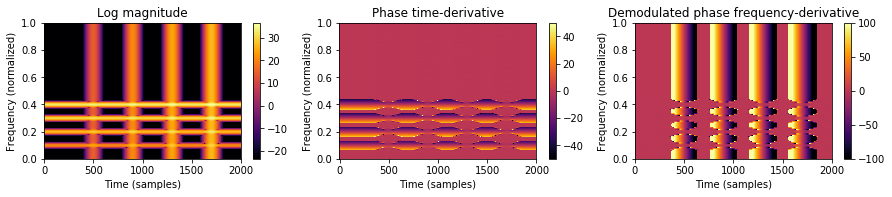

In [237]:
mpl.rcParams['image.cmap'] =  'inferno'
plt.figure(figsize=(15,2.5));
plt.subplot(131);
ltfatpy.plotdgtreal(c,a,M,dynrange=60);
plt.title('Log magnitude')
# plt.subplot(142);
# ltfatpy.plotdgtreal(unwrap(np.angle(c)),a,M, normalization='lin');
# plt.title('Phase unwrapped in time')
plt.subplot(132);
ltfatpy.plotdgtreal(tgrad*(np.abs(c) > np.exp(-5)),a,M,clim=[-50,50], normalization='lin');
plt.title('Phase time-derivative')
plt.subplot(133);
ltfatpy.plotdgtreal(fgrad*(np.abs(c) > np.exp(-5)),a,M,clim=[-100,100], normalization='lin');
plt.title('Demodulated phase frequency-derivative')
plt.savefig("intro-TF.pdf", bbox_inches='tight')

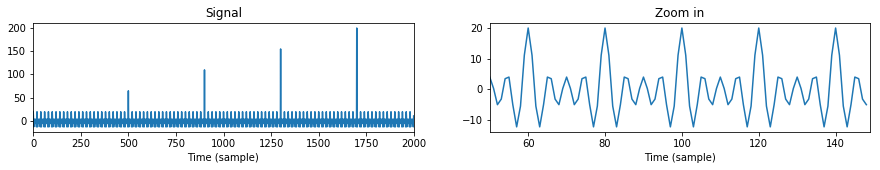

In [238]:
plt.figure(figsize=(15, 2))
plt.subplot(121)
plt.plot(f)
plt.xlim([0,L-1])
plt.xlabel('Time (sample)')
plt.title('Signal')

plt.subplot(122)
lim = [50,150-1]
plt.plot(range(*lim),f[lim[0]:lim[1]])
plt.xlim(lim)
plt.xlabel('Time (sample)')
plt.title('Zoom in')

plt.savefig("intro-time.pdf", bbox_inches='tight')